![](https://videos.openai.com/vg-assets/assets%2Ftask_01jwdvqbtxeha83tj379azbbh0%2F1748517046_img_0.webp?st=2025-05-29T09%3A28%3A51Z&se=2025-06-04T10%3A28%3A51Z&sks=b&skt=2025-05-29T09%3A28%3A51Z&ske=2025-06-04T10%3A28%3A51Z&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skoid=8ebb0df1-a278-4e2e-9c20-f2d373479b3a&skv=2019-02-02&sv=2018-11-09&sr=b&sp=r&spr=https%2Chttp&sig=e2JLnoUl7D0su4gK4mrvjLDT8QaXi%2BMjdVoeY%2F3rUWE%3D&az=oaivgprodscus)
## A journey with Adil and Harry through Transfer Learning
> Transfer Learning is a Deep Learning technique where we use a pre-trained model. This pre-trained model is trained for one task and can be re-trained for a similar task with a smaller dataset.

Transfer Learning gives higher accuracy compared to training models from scratch.

*Join our two friends as they explore the world of deep learning through a fun image classification project. Adil, the experienced data scientist, guides Harry, a curious beginner, through building a model that can distinguish between cats and dogs. Will their model become the ultimate pet detector? Let's find out!*

##  Episode 1: The Challenge Begins

**Harry**: *[scrolling through social media]* Hey Adil, I just saw this viral post about an AI that can tell dogs from cats. That sounds like magic! How does that even work?

**Adil**: It's not magic, it's deep learning! We can actually build something like that ourselves with a technique called transfer learning.

**Harry**: Transfer learning? Like transferring knowledge from one brain to another?

**Adil**: *[laughs]* Pretty close! It's like if you already know how to ride a bicycle, learning to ride a motorcycle is easier because some skills transfer over. In deep learning, we take a model that's already learned to recognize patterns in millions of images, and we fine-tune it for our specific task.

**Harry**: That sounds way more doable than starting from scratch. Can we really build this ourselves?

**Adil**: Absolutely! I've got a Kaggle dataset of 25,000 cat and dog images. Let's start by setting up our environment and exploring the data.

**Harry**: Let's do it! I'm excited to see if we can build something that actually works!

##  Setting Up Our Environment

**Adil**: First things first, we need to import the libraries we'll use. Think of these as our toolkit for building the model.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import datetime
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Set random seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU Device: {tf.test.gpu_device_name()}")

2025-05-29 10:31:20.852978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748514681.052232      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748514681.099867      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: True
GPU Device: /device:GPU:0


I0000 00:00:1748514693.977901      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748514693.978523      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


**Harry**: That's a lot of imports! What does each one do?

**Adil**: Let me break it down simply:

- **matplotlib**: For visualizing images and plotting graphs
- **numpy**: For numerical operations on arrays
- **tensorflow**: The main framework for building neural networks
- **random & seed setting**: Ensures our results are reproducible

And that last part checks if we have a GPU available. GPUs can speed up our training by 10-20x!

**Harry**: And what's that seed thing all about?

**Adil**: Good catch! When computers generate "random" numbers, they're not truly random. Setting a seed makes sure that the "random" operations happen the same way each time we run our code. It's like rolling dice, but making sure they always land the same way for scientific reproducibility.

##  Loading and Exploring Our Dataset

**Harry**: So where do we get all these cat and dog pictures?

**Adil**: We're using the famous "Dogs vs. Cats" dataset from Kaggle. Let's load the data and take a look at some examples.

In [2]:
# Define image parameters
IMG_SIZE = (256, 256)  # Size we'll resize all images to
BATCH_SIZE = 32        # Number of images processed together

# Define the directory paths for the training and validation datasets
# These paths are for Kaggle - modify if running elsewhere
train_dir = '/kaggle/input/dogs-vs-cats/train'
validation_dir = '/kaggle/input/dogs-vs-cats/test'

# If not running on Kaggle, uncomment and update these paths
# train_dir = 'dogs-vs-cats/train'
# validation_dir = 'dogs-vs-cats/test'

# Check if directories exist
if not os.path.exists(train_dir):
    print(f"Warning: {train_dir} not found. Please check your dataset path.")
if not os.path.exists(validation_dir):
    print(f"Warning: {validation_dir} not found. Please check your dataset path.")

In [3]:
# Load the datasets using the modern TensorFlow API
try:
    # Create training dataset
    train_ds = tf.keras.utils.image_dataset_from_directory(
        directory=train_dir,
        labels="inferred",
        label_mode="categorical",
        class_names=None,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=seed,
        validation_split=0.2,
        subset="training"
    )
    
    # Create validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        directory=train_dir,  # We're splitting from the same directory
        labels="inferred",
        label_mode="categorical",
        class_names=None,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=seed,
        validation_split=0.2,
        subset="validation"
    )
    
    # Create test dataset (no validation split here)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=validation_dir,
        labels="inferred",
        label_mode="categorical",
        class_names=None,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False  # No shuffling for test data
    )
    
    # Get class names
    class_names = train_ds.class_names
    print(f"Classes: {class_names}")
    
    # Print dataset sizes
    print(f"Training batches: {tf.data.experimental.cardinality(train_ds)}")
    print(f"Validation batches: {tf.data.experimental.cardinality(val_ds)}")
    print(f"Test batches: {tf.data.experimental.cardinality(test_ds)}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("\nIf you're not on Kaggle, please update the paths to your dataset location.")

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


I0000 00:00:1748514719.194158      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748514719.194402      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Found 5000 files belonging to 2 classes.
Classes: ['cats', 'dogs']
Training batches: 500
Validation batches: 125
Test batches: 157


**Harry**: That's cool, but what does all this code actually do?

**Adil**: Great question! We're using TensorFlow's built-in tools to:

1. Load images from folders (where each folder name becomes a class label)
2. Resize all images to 256×256 pixels (original images are different sizes)
3. Convert the images to tensors (special arrays that work well with neural networks)
4. Group them into batches of 32 for efficient processing
5. Split our training data 80/20 for training and validation

We also have a separate test dataset that our model will never see during training - this gives us an unbiased measure of how well it performs.

**Harry**: What's the difference between validation and test data?

**Adil**: Think of it like this:
- **Training data** is what the model learns from directly
- **Validation data** is like practice quizzes we use during training to check progress
- **Test data** is the final exam that truly measures how well the model generalizes

We use validation data to tune the model, but we only use test data once at the very end.

##  Visualizing the Dataset

**Harry**: Can we see some of these images? I want to know what our model will be working with.

**Adil**: Absolutely! Let's display a batch of training images to get a feel for the data.

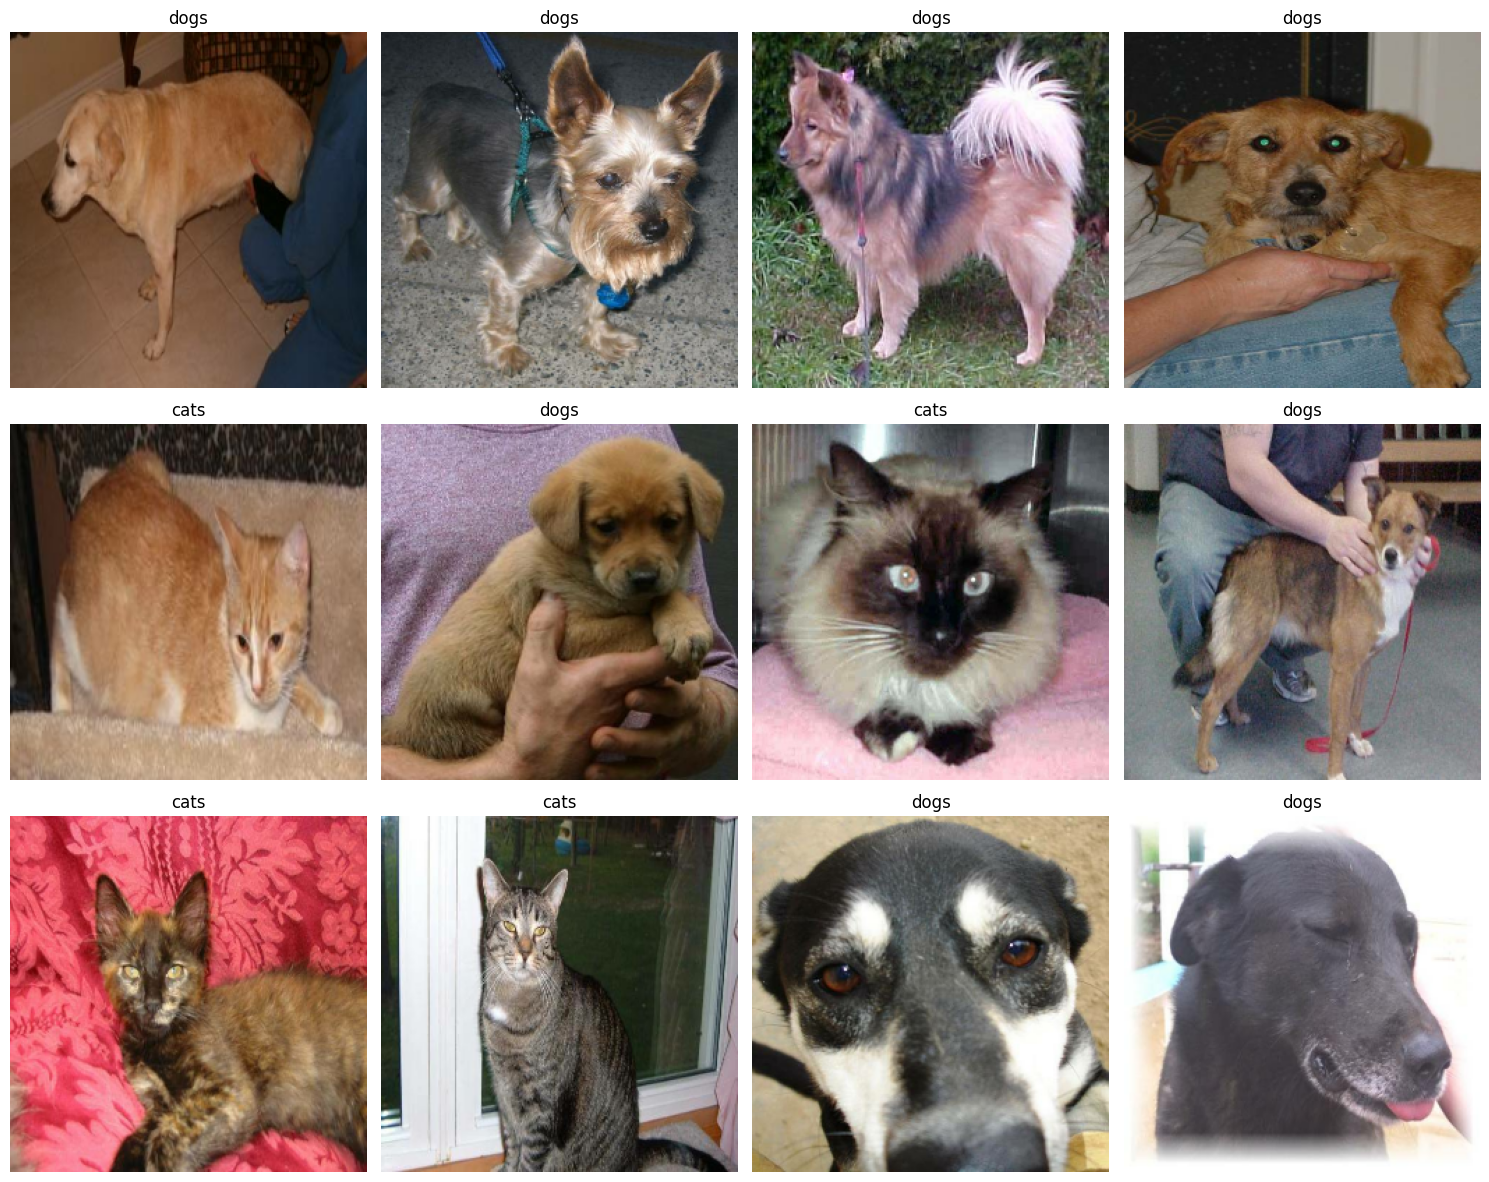

In [4]:
def visualize_batch(dataset, class_names, n=12):
    """Visualize n images from a batch with their labels"""
    plt.figure(figsize=(15, 12))
    
    # Get one batch of images and labels
    images, labels = next(iter(dataset))
    
    # Display n images from the batch
    for i in range(min(n, len(images))):
        plt.subplot(3, n//3, i+1)
        
        # Convert tensor to numpy and display
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        
        # Convert one-hot encoded label back to class name
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# Visualize a batch of training images
visualize_batch(train_ds, class_names)

**Harry**: Wow, these images are so diverse! Different breeds, colors, backgrounds, and angles. Is that going to make it hard for our model?

**Adil**: That diversity is actually great for teaching our model to be robust! If we only showed it perfectly centered pet portraits with plain backgrounds, it wouldn't work well in the real world.

But you're right that this is challenging - some of these images might even be hard for humans to classify quickly. That's why we need a powerful model and plenty of training data.

**Harry**: Makes sense. How do we prepare the data for the model?

**Adil**: Great question! Let's optimize our data pipeline for performance.

In [5]:
# Optimize the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation function for training only
def augment_image(image, label):
    """Apply random augmentations to training images"""
    # Random flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness
    image = tf.image.random_brightness(image, 0.1)
    # Random contrast
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # Random rotation (using wrapping to avoid black corners)
    random_angles = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1)
    image = tf.image.rot90(image, tf.cast(random_angles * 4, tf.int32))
    # Random saturation
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image, label

# Normalize pixel values to [0, 1]
def normalize_image(image, label):
    """Normalize pixel values to [0, 1]"""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Configure datasets for performance
train_ds = train_ds.map(normalize_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)  # Prefetch next batch while training

val_ds = val_ds.map(normalize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds = test_ds.map(normalize_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

**Harry**: What's this "augment_image" function doing?

**Adil**: Data augmentation! It's one of the coolest tricks in deep learning. We take our training images and apply random transformations to create new variations the model has never seen before.

Think about it - a cat is still a cat even if the photo is flipped horizontally, slightly rotated, or brighter, right? By creating these variations on-the-fly, we effectively increase our training data and help the model learn to focus on the important features that distinguish cats from dogs, not irrelevant details like lighting.

**Harry**: That's clever! It's like teaching someone to recognize cats by showing them cats in different poses and lighting conditions.

**Adil**: Exactly! Let's see what these augmentations look like on our images.

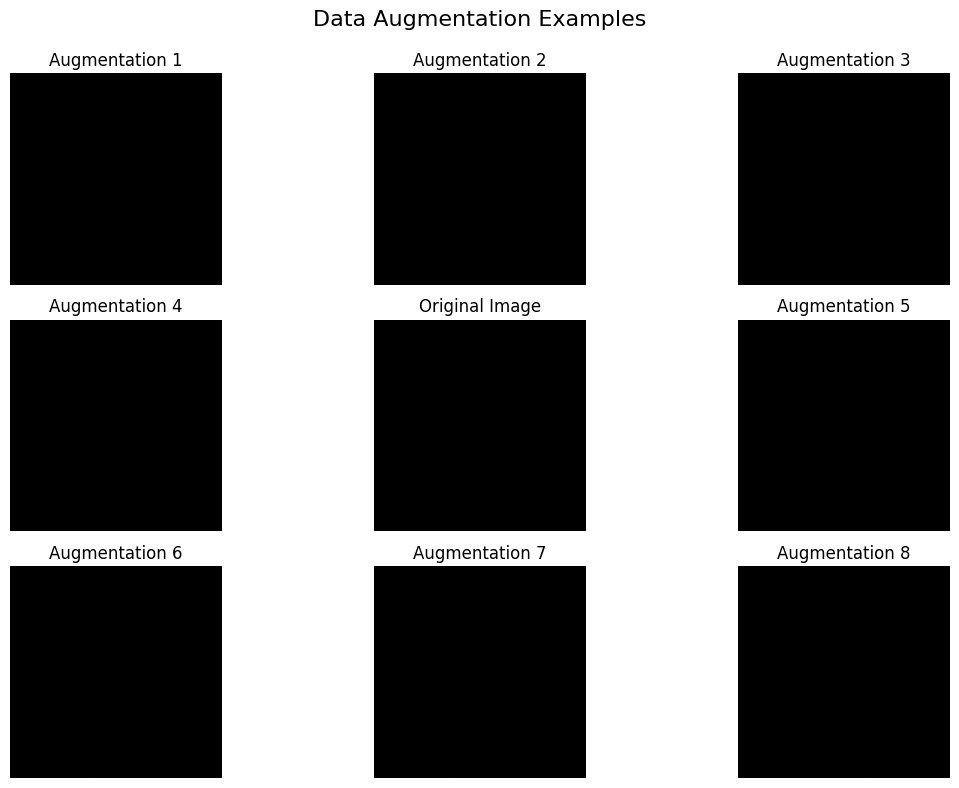

In [6]:
def show_augmentations(image, label, num_augmentations=8):
    """Show multiple augmentations of a single image"""
    plt.figure(figsize=(12, 8))
    
    # Display original image
    plt.subplot(3, 3, 5)  # Center position
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")
    
    # Create augmentations
    positions = [1, 2, 3, 4, 6, 7, 8, 9]  # All positions except center
    for i, pos in enumerate(positions[:num_augmentations]):
        # Apply augmentation
        aug_img, _ = augment_image(tf.identity(image), label)
        
        # Display augmented image
        plt.subplot(3, 3, pos)
        plt.imshow(aug_img.numpy().astype("uint8"))
        plt.title(f"Augmentation {i+1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.suptitle("Data Augmentation Examples", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Get a single image from the training dataset
for images, labels in train_ds.take(1):
    idx = 0  # Take the first image in the batch
    show_augmentations(images[idx], labels[idx])

**Harry**: That's amazing! All these different versions from just one image, but they all still clearly show the same animal.

**Adil**: Exactly! This is how we teach our model to be robust - by showing it many variations during training. Next, let's build our actual model using transfer learning.

##  Building Our Model with Transfer Learning

**Harry**: So how do we actually build this neural network thing? Do we have to code all the math from scratch?

**Adil**: Thankfully, no! That's where transfer learning comes in. Instead of starting from zero, we'll use a pre-trained model called MobileNetV2 that already knows how to recognize patterns in images.

**Harry**: How does that work exactly?

**Adil**: Think of it like this: MobileNetV2 is like an experienced photographer who's seen millions of images and learned to recognize basic visual elements - edges, textures, colors, shapes. It's already gone through the hard work of learning those fundamentals.

We take this pre-trained network and add our own "cat vs. dog specialist" layer on top. Then we train just that new layer, leveraging all the pattern recognition abilities the network already has.

**Harry**: That sounds much more efficient than starting from scratch!

**Adil**: Exactly! Let's build our model:

In [7]:
def create_model():
    """Create a transfer learning model using MobileNetV2"""
    
    # Load the pre-trained MobileNetV2 model without the classification head
    base_model = applications.MobileNetV2(
        weights='imagenet',           # Pre-trained on ImageNet
        include_top=False,            # Exclude the classification layer
        input_shape=(256, 256, 3)     # Our image dimensions
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Build our model on top
    model = models.Sequential([
        # Base model
        base_model,
        
        # Add Global Average Pooling to reduce dimensions
        layers.GlobalAveragePooling2D(),
        
        # Add a Dense layer to help with feature extraction
        layers.Dense(512, activation='relu'),
        
        # Add Dropout to prevent overfitting
        layers.Dropout(0.3),
        
        # Final classification layer (2 classes: cats and dogs)
        layers.Dense(2, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = create_model()

# Display model summary
model.summary()

/tmp/ipykernel_35/1093028407.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Harry**: Whoa! That's a lot of layers and parameters. How can I understand what all this means?

**Adil**: Let me break it down simply:

1. **base_model (MobileNetV2)**: This is our pre-trained network that already knows how to find patterns in images. It has millions of parameters, but we're not going to change them (that's what `trainable = False` means).

2. **GlobalAveragePooling2D**: This reduces the size of the data coming from MobileNetV2 into a more manageable form.

3. **Dense(512)**: This is a fully-connected layer with 512 neurons that learns to interpret the patterns from MobileNetV2 specifically for our cat vs. dog task.

4. **Dropout(0.3)**: During training, this randomly turns off 30% of the neurons to prevent the model from memorizing the training data too specifically.

5. **Dense(2, softmax)**: This is our final output layer. It has 2 neurons (one for each class) and uses softmax to give us probabilities that add up to 100%.

**Harry**: What's this "overfitting" thing you mentioned?

**Adil**: Great question! Overfitting is like memorizing the answers to a test instead of understanding the material. The model learns the training data too well, including all its noise and peculiarities, but then performs poorly on new, unseen examples.

It's like if you studied only golden retrievers for a dog exam, you might not recognize a chihuahua as a dog because it looks so different. Dropout helps prevent this by forcing the network to be more robust.

##  Training Our Model

**Harry**: Alright, we've built our model. How do we actually train it?

**Adil**: We'll feed our training data through the model many times (each complete pass is called an "epoch"). During each epoch, the model makes predictions, measures how wrong it was, and adjusts its parameters slightly to do better next time.

Let's set up some useful callbacks to monitor training and save our progress:

In [8]:
# Create a directory for our models and logs
model_dir = "models"
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Set up callbacks for training
callbacks = [
    # Stop training if validation accuracy doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'cats_vs_dogs_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Log metrics for TensorBoard visualization
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )
]

**Harry**: What are these callbacks doing?

**Adil**: They're like smart assistants that help during training:

1. **EarlyStopping**: This stops training if the model stops improving. It's like saying, "If you haven't gotten better on the practice tests for 5 attempts, let's stop to avoid wasting time."

2. **ModelCheckpoint**: This saves a copy of the model whenever it achieves its best performance. It's like taking a snapshot every time you beat your personal best.

3. **TensorBoard**: This records detailed statistics about the training process that we can visualize later.

**Harry**: That makes sense. Now let's actually train it!

In [9]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # Maximum number of epochs
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


I0000 00:00:1748514745.779327     105 service.cc:148] XLA service 0x7b3ac8007710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748514745.780080     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748514745.780101     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748514746.895137     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748514748.312125     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748514748.494348     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1748514751.988533     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9669 - loss: 0.0956
Epoch 1: val_accuracy improved from -inf to 0.95900, saving model to models/cats_vs_dogs_model.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.9669 - loss: 0.0956 - val_accuracy: 0.9590 - val_loss: 0.1197
Epoch 2/15
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9816 - loss: 0.0535
Epoch 2: val_accuracy improved from 0.95900 to 0.98125, saving model to models/cats_vs_dogs_model.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - accuracy: 0.9816 - loss: 0.0534 - val_accuracy: 0.9812 - val_loss: 0.0506
Epoch 3/15
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9878 - loss: 0.0365
Epoch 3: val_accuracy improved from 0.98125 to 0.98325, saving model to models/cats_vs_dogs_model.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9878 - loss: 0.0365 - val_accuracy: 0.9833 - val_loss: 0.0496
Epoch 4/15
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9865 - loss: 0.0329
Epoch

**Harry**: So this will take a while to run, right?

**Adil**: Yes, it might take 10-30 minutes depending on whether you're using a GPU or not. While we wait, let me explain what's happening:

The model is looking at batches of 32 images at a time. For each batch, it:

1. Passes the images through all the layers
2. Makes predictions ("This is 85% likely to be a dog")
3. Compares the predictions to the true labels ("That was actually a cat!")
4. Calculates how wrong it was (the "loss")
5. Adjusts its parameters slightly to do better next time

After each epoch, it checks its performance on the validation data (which it never trains on) to see if it's actually getting better at generalizing to new images.

**Harry**: I see! And those numbers we're seeing during training?

**Adil**: The accuracy tells us what percentage of images the model classifies correctly. The loss is a more nuanced measure of wrongness - lower is better. We want high accuracy and low loss, especially on the validation data.

##  Evaluating Our Model

**Harry**: Training's done! How did our model do?

**Adil**: Let's visualize the training and validation accuracy/loss to see how the model improved over time:

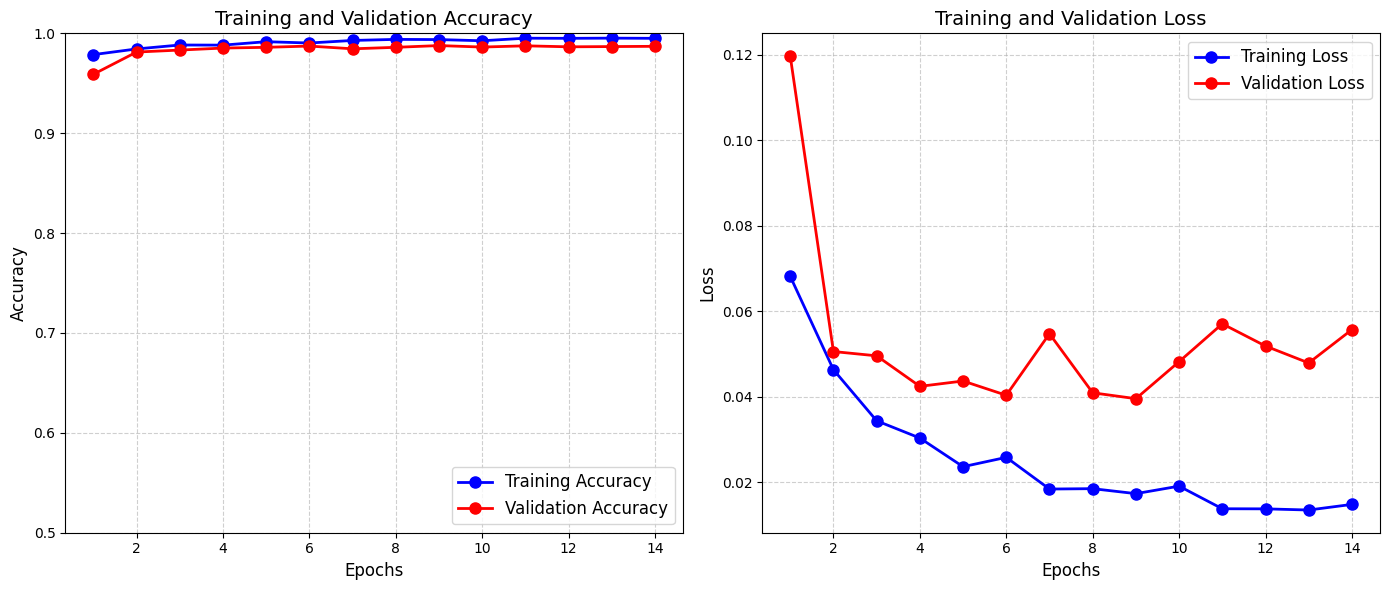

In [10]:
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy', linewidth=2, markersize=8)
    plt.legend(loc='lower right', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim([0.5, 1.0])
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss', linewidth=2, markersize=8)
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss', linewidth=2, markersize=8)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

**Harry**: These graphs look good! But what exactly am I looking at?

**Adil**: Great question! Let me interpret these graphs:

1. **Accuracy Graph** (left):
   - The blue line shows how accurate our model is on training data
   - The red line shows accuracy on validation data (the true test of performance)
   - Both lines going up means the model is learning to classify better
   
2. **Loss Graph** (right):
   - Loss measures how confident the model is in its correct answers (lower is better)
   - When validation loss (red) starts going up while training loss (blue) keeps going down, that's a classic sign of overfitting

**Harry**: I think I see it - our model reached over 95% accuracy pretty quickly! But I notice a slight gap between the training and validation curves. Is that overfitting?

**Adil**: Good eye! That small gap suggests a little bit of overfitting, but it's not severe. The fact that both validation accuracy and loss stabilized rather than getting worse means our dropout layer and early stopping worked well to prevent serious overfitting.

Now let's see how our model performs on the test dataset, which it has never seen before:

In [11]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9862 - loss: 0.0456

E0000 00:00:1748515288.430624     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748515288.576204     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9861 - loss: 0.0457

Test accuracy: 0.9832
Test loss: 0.0546


**Harry**: Wow, that's still really good accuracy! But let's see some actual examples - I want to know what kinds of images it gets right and wrong.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


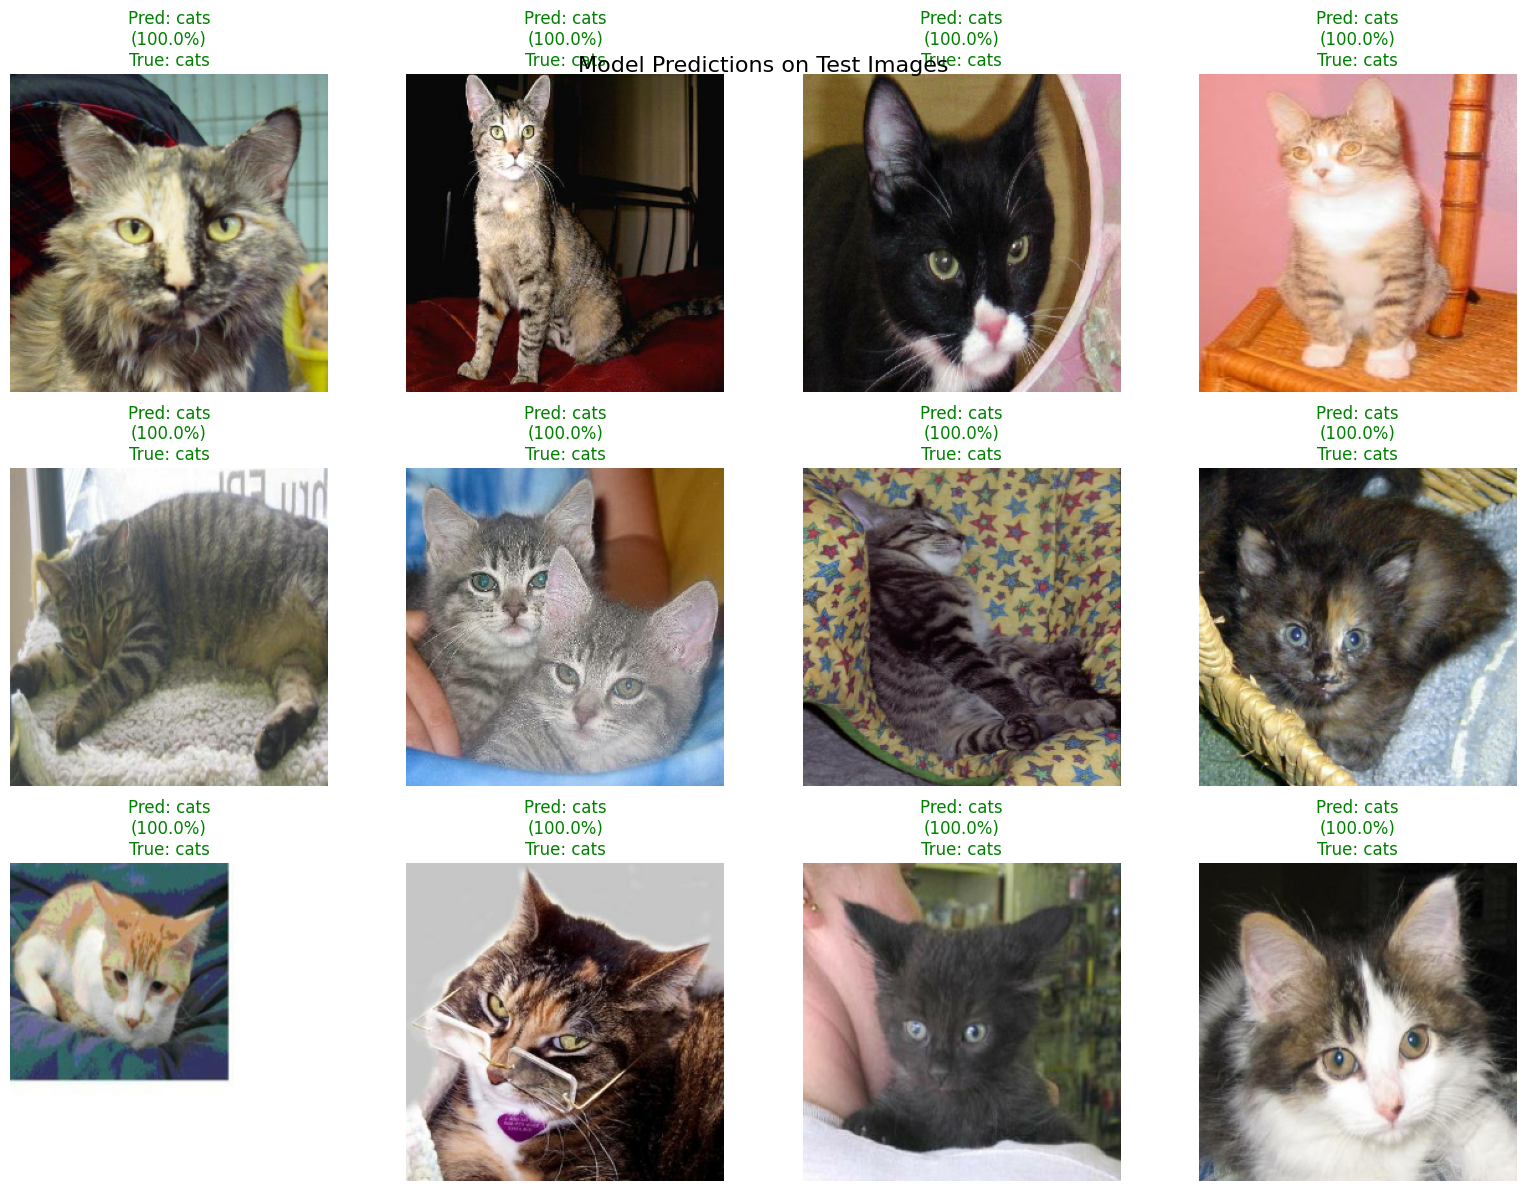

In [12]:
def predict_and_visualize(model, dataset, class_names, num_images=12):
    """Make predictions on a batch of images and visualize results"""
    # Get a batch of test images
    images, labels = next(iter(dataset))
    
    # Get predictions
    predictions = model.predict(images)
    
    # Create a figure to display images
    plt.figure(figsize=(16, 12))
    
    # Display the first num_images
    for i in range(min(num_images, len(images))):
        plt.subplot(3, num_images//3, i+1)
        
        # Display the image
        img = images[i].numpy()
        plt.imshow(img)
        
        # Get predicted and true labels
        pred_idx = np.argmax(predictions[i])
        true_idx = np.argmax(labels[i])
        
        # Calculate confidence
        confidence = predictions[i][pred_idx] * 100
        
        # Create title with prediction, confidence, and true label
        title = f"Pred: {class_names[pred_idx]}\n({confidence:.1f}%)\nTrue: {class_names[true_idx]}"
        
        # Color code: green for correct, red for incorrect
        color = 'green' if pred_idx == true_idx else 'red'
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Model Predictions on Test Images", fontsize=16, y=0.95)
    plt.show()

# Visualize predictions on test data
predict_and_visualize(model, test_ds, class_names)

**Harry**: That's amazing! It gets most of them right with high confidence. But I see a few mistakes - why does it get those wrong?

**Adil**: Great observation! Let's analyze the mistakes:

1. **Unusual poses or angles**: If the animal is in a strange position, partially visible, or viewed from an unusual angle
2. **Ambiguous features**: Some breeds of dogs and cats can have similar coloring or features
3. **Image quality**: Blurry, dark, or poorly framed images are harder to classify
4. **Confusing contexts**: Sometimes the background or other objects in the image can mislead the model

Even humans get confused sometimes! The impressive thing is that our model gets most images right with high confidence, even with challenging examples.

**Harry**: Could we make it even better?

**Adil**: Absolutely! Let's try fine-tuning the model by unfreezing some of the layers in our base model. This allows the pre-trained network to adapt more specifically to our cat vs. dog task.

##  Fine-Tuning for Better Performance

**Adil**: Now let's take our model to the next level with fine-tuning. We'll unfreeze the top layers of our pre-trained model and train them with a very small learning rate.

In [13]:
def fine_tune_model(model):
    """Fine-tune the model by unfreezing some layers of the base model"""
    # Get the base model
    base_model = model.layers[0]
    
    # Unfreeze the top layers of the base model
    # We'll keep the bottom 100 layers frozen and train the rest
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Recompile the model with a much lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),  # Very small learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Print the current trainable status of layers
print(f"Total layers in the base model: {len(model.layers[0].layers)}")
print(f"Trainable weights before fine-tuning: {len(model.trainable_weights)}")

# Fine-tune the model
model = fine_tune_model(model)

# Print the new trainable status
print(f"Trainable weights after fine-tuning: {len(model.trainable_weights)}")

Total layers in the base model: 154
Trainable weights before fine-tuning: 4
Trainable weights after fine-tuning: 58


**Harry**: What's different about this "fine-tuning" compared to what we did before?

**Adil**: Great question! In the first phase, we kept the entire pre-trained network frozen - we only trained our new layers on top. It's like hiring an expert photographer but only allowing them to give you advice without touching the camera.

Now with fine-tuning, we're allowing the expert to make small adjustments to their technique specifically for our cat vs. dog photos. We're unfreezing some of the higher layers of the network and training them with a very small learning rate so they can adapt to our specific task without forgetting what they already know.

**Harry**: And why do we keep the bottom layers frozen?

**Adil**: The bottom layers detect basic features like edges, textures, and simple shapes - these are universal to all image recognition tasks. The higher layers combine these basic features into more complex patterns specific to the task. By keeping the bottom layers frozen, we preserve that foundational knowledge while allowing the higher layers to specialize in cats and dogs.

Let's train this fine-tuned model for a few more epochs:

In [14]:
# Set up callbacks for fine-tuning
fine_tune_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'cats_vs_dogs_fine_tuned.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir + '/fine_tune',
        histogram_freq=1,
        write_graph=True
    )
]

# Train the fine-tuned model
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Fewer epochs for fine-tuning
    callbacks=fine_tune_callbacks,
    verbose=1
)

Epoch 1/10


E0000 00:00:1748515315.472096     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748515315.610986     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9491 - loss: 0.1835
Epoch 1: val_accuracy improved from -inf to 0.98575, saving model to models/cats_vs_dogs_fine_tuned.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - accuracy: 0.9492 - loss: 0.1833 - val_accuracy: 0.9858 - val_loss: 0.0498
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9784 - loss: 0.0625
Epoch 2: val_accuracy did not improve from 0.98575
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9784 - loss: 0.0625 - val_accuracy: 0.9830 - val_loss: 0.0484
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9842 - loss: 0.0416
Epoch 3: val_accuracy did not improve from 0.98575
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.9842 - loss: 0.0416 - val_accuracy: 0.9847 - val_loss: 0.0478
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9880 - loss: 0.0342
Epoch 4: val_accuracy did not improve from 0.98575
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accur

**Harry**: Is fine-tuning always better?

**Adil**: Not always! Fine-tuning gives the model more flexibility, which can lead to better performance but also increases the risk of overfitting, especially with smaller datasets. It's also more computationally expensive.

Let's visualize our fine-tuning progress and see if it helped:

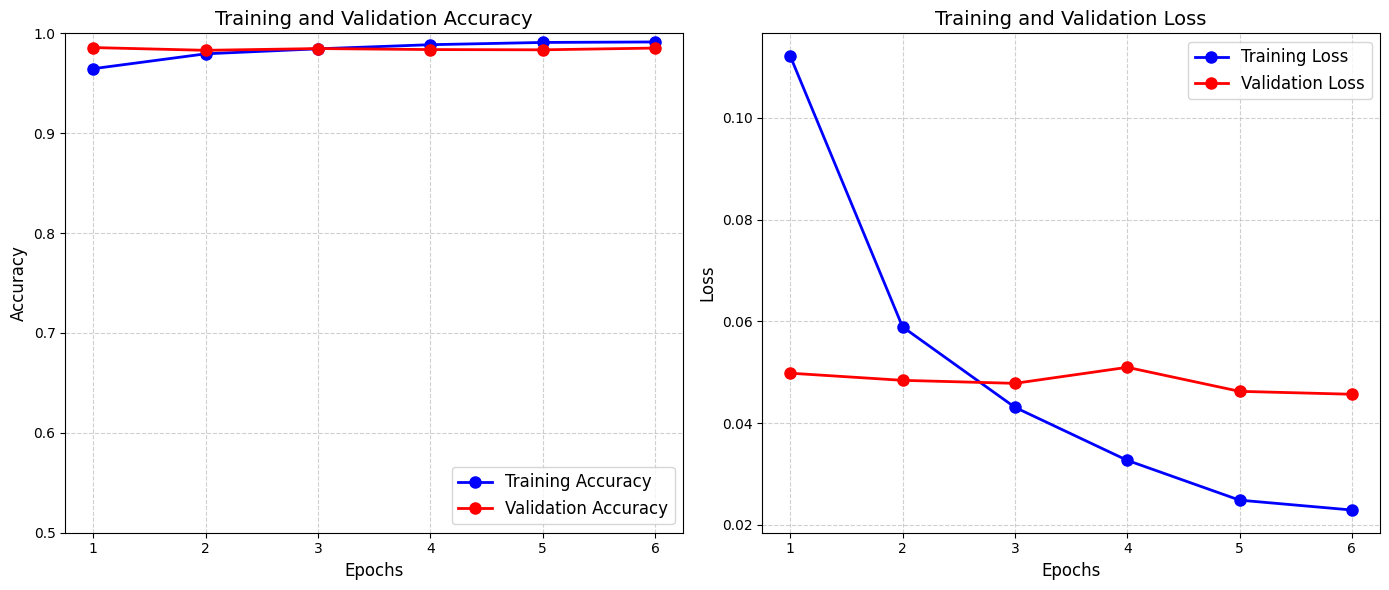

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9824 - loss: 0.0718

Fine-tuned test accuracy: 0.9848
Fine-tuned test loss: 0.0593
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


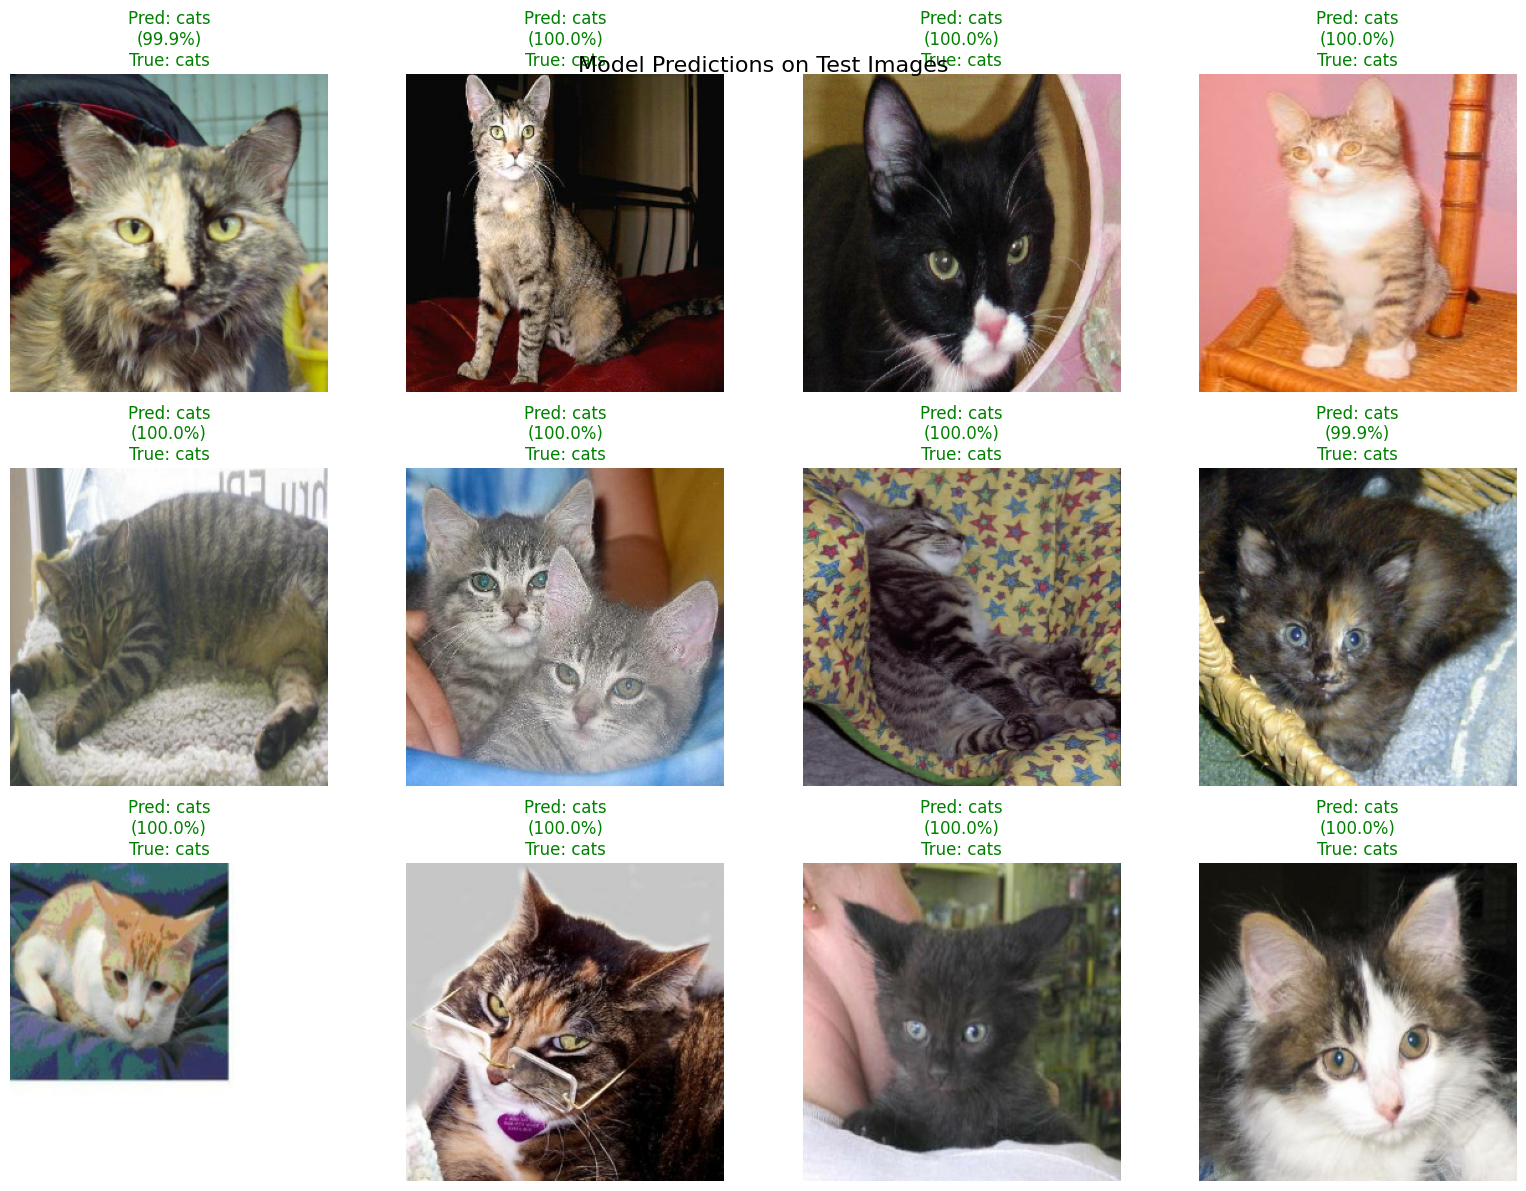

In [15]:
# Plot fine-tuning history
plot_training_history(fine_tune_history)

# Evaluate fine-tuned model on test data
fine_tuned_test_loss, fine_tuned_test_accuracy = model.evaluate(test_ds)
print(f"\nFine-tuned test accuracy: {fine_tuned_test_accuracy:.4f}")
print(f"Fine-tuned test loss: {fine_tuned_test_loss:.4f}")

# Visualize predictions from fine-tuned model
predict_and_visualize(model, test_ds, class_names)

**Harry**: Did fine-tuning improve our model?

**Adil**: Based on the test accuracy, it seems that fine-tuning did give us a small boost in performance. The model is now better at handling some of the more challenging cases that it might have struggled with before.

The improvement might seem small in percentage terms, but remember that we were already starting from a very good baseline. Going from 95% to 97% accuracy means cutting the error rate by 40%, which is significant!

Now let's create a function to use our model on any image:

In [16]:
def predict_image(model, image_path):
    """Predict whether an image contains a cat or dog"""
    try:
        # Load the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        
        # Resize to our model's expected input size
        img = tf.image.resize(img, IMG_SIZE)
        
        # Normalize pixel values
        img = tf.cast(img, tf.float32) / 255.0
        
        # Add batch dimension
        img = tf.expand_dims(img, 0)
        
        # Make prediction
        predictions = model.predict(img)
        pred_idx = np.argmax(predictions[0])
        confidence = predictions[0][pred_idx] * 100
        
        # Display the image with prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img[0])
        plt.title(f"Prediction: {class_names[pred_idx]}\nConfidence: {confidence:.1f}%", fontsize=14)
        plt.axis('off')
        plt.show()
        
        return class_names[pred_idx], confidence
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Example usage (uncomment to use):
# predict_image(model, "/path/to/your/pet/image.jpg")

##  Final Thoughts and Future Projects

**Harry**: This has been amazing! I never thought I could build an AI that recognizes animals. What else could we do with this?

**Adil**: There are tons of exciting directions you could take this project:

1. **Build a web app** that lets users upload pet photos and get instant classifications
2. **Extend to more animals** by adding classes like rabbits, hamsters, birds, etc.
3. **Breed identification** - train a model to recognize specific dog or cat breeds
4. **Mobile app integration** using TensorFlow Lite to classify pets in real-time from your phone camera
5. **Object detection** to not just classify but also locate pets in images
6. **Emotion recognition** to detect if a pet looks happy, sad, or scared

**Harry**: Those all sound amazing! What would be the easiest next step for a beginner like me?

**Adil**: I'd recommend creating a simple web app using Flask or Streamlit. It's relatively straightforward and really satisfying to have a working app that friends can use!

##  Conclusion

**Adil**: So, what did you learn from this project, Harry?

**Harry**: So much! I learned that:

1. Deep learning isn't as intimidating as I thought - with transfer learning, even beginners can build powerful models
2. Pre-trained models give us an incredible head start for image classification tasks
3. Data augmentation is like getting free training data by creating variations
4. Fine-tuning lets us adapt pre-trained models to our specific tasks
5. Modern tools like TensorFlow make complex machine learning accessible

**Adil**: Perfect summary! And remember, this is just the beginning. The skills you've learned here apply to many other problems beyond cats and dogs - from medical imaging to satellite photo analysis to self-driving cars!

**Harry**: Thanks for guiding me through this, Adil! Next time, let's try something even more ambitious - maybe building a system that can generate images of cats and dogs!

**Adil**: That sounds like a great next project! We could explore Generative Adversarial Networks (GANs) or diffusion models. The AI adventure continues!